# Train A Shape Classifier Model



In [2]:
import json
import os
train_data_root = "../datasets/train"
test_data_root = "../datasets/test"

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations (including resizing and normalization)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale (black and white images)
    transforms.Resize((64, 64)),  # Resize images to 64x64 pixels
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the images (mean=0.5, std=0.5 for grayscale)
])

# Load the dataset
train_dataset = datasets.ImageFolder(root=train_data_root, transform=transform)
test_dataset = datasets.ImageFolder(root=test_data_root, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check class names (optional)
print(f'Classes: {train_dataset.classes}')

# 2. Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # ERROR 1 Adjust the right kernel size 
        # For the CNN model the size of the input and output kernel size should be the same 
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 3)  # 3 classes: circle, triangle, rectangle
        
    def forward(self, x):
        x = F.relu(self.conv1(x))   # First Conv Layer
        x = F.max_pool2d(x, 2)      # Max Pooling
        x = F.relu(self.conv2(x))   # Second Conv Layer
        x = F.max_pool2d(x, 2)      # Max Pooling
        x = x.view(x.size(0), -1)   # Flatten
        x = F.relu(self.fc1(x))     # Fully Connected Layer 1
        x = self.fc2(x)             # Fully Connected Layer 2 (output)
        return x

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # ERROR 2
        # Get the real accuracy value 
        accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%')


Classes: ['circle', 'diamond', 'triangle']


# Train

In [4]:
train_model(model, train_loader, criterion, optimizer, epochs=15)

Epoch [1/15], Loss: 1.0899, Accuracy: 37.57%
Epoch [2/15], Loss: 0.9999, Accuracy: 49.86%
Epoch [3/15], Loss: 0.8635, Accuracy: 59.86%
Epoch [4/15], Loss: 0.6583, Accuracy: 73.86%
Epoch [5/15], Loss: 0.4424, Accuracy: 82.71%
Epoch [6/15], Loss: 0.3126, Accuracy: 88.29%
Epoch [7/15], Loss: 0.2063, Accuracy: 93.57%
Epoch [8/15], Loss: 0.1487, Accuracy: 95.14%
Epoch [9/15], Loss: 0.1020, Accuracy: 97.29%
Epoch [10/15], Loss: 0.0674, Accuracy: 98.57%
Epoch [11/15], Loss: 0.0367, Accuracy: 99.71%
Epoch [12/15], Loss: 0.0245, Accuracy: 99.86%
Epoch [13/15], Loss: 0.0194, Accuracy: 99.71%
Epoch [14/15], Loss: 0.0106, Accuracy: 100.00%
Epoch [15/15], Loss: 0.0065, Accuracy: 100.00%


# Test 

In [5]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Test the mode
def test_model(model, test_loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    # Store the label of the results 
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # getting the output using the train model
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total

    # Print out the precision, recall and F1 score
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Test Loss: {running_loss/len(test_loader):.4f}, Accuracy: {accuracy:.2f}%')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')

    return precision, recall, f1


In [6]:
test_model(model, test_loader)

Accuracy: 74.6667
Test Loss: 0.9777, Accuracy: 74.67%
Precision: 0.7611, Recall: 0.7467, F1-score: 0.7522


(0.7610702399861692, 0.7466666666666667, 0.7522413628330257)

# Show Predictions


In [15]:
from PIL import Image
import matplotlib.pyplot as plt
def show_prediction(model, image_path):
    model.eval()

    image = Image.open(image_path)  
    # Data preprocessing
    transformed = transform(image).unsqueeze(0).to(device) 

    # Predict the output
    with torch.no_grad():
        output = model(transformed)
        probs = F.softmax(output, dim=1)
        confidence, predicted = torch.max(probs, 1)
    # Visualize the result 
    plt.imshow(image.convert("L"), cmap='gray')
    # Comparing the predicted shape and the actual shape
    plt.title(f"Prediction: {train_dataset.classes[predicted.item()]} ({confidence.item()*100:.1f}%)")
    plt.axis("off")
    plt.show()

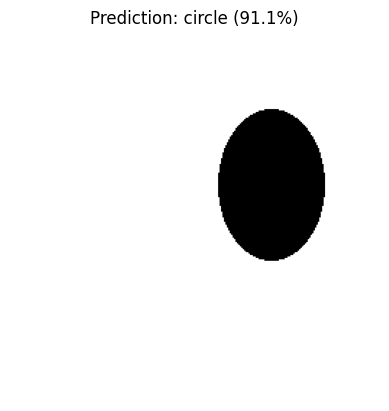

In [16]:
# Getting the output 
show_prediction(model,'../datasets/test/circle/circle_3.png')